# Contents
* Load Dataset
* EDA print samples
* Preprocesss - convert into tensors, train split 
* Create batch size and data loaders
* Move to devices
* Create model
* Create fit function
* Create acuracy evaluate function
* Train
* Print results
* Plot curves and predictions

# Imports

In [ ]:
import torch
import torchvision
from  torch.utils.data.dataloader import DataLoader
import torch.nn.functional as F
import os
import tarfile
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
import matplotlib.pyplot as plt


In [ ]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

In [ ]:
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [ ]:
os.listdir('./data/cifar10')

['test', 'train']

# PreProcess

In [ ]:
dataset = ImageFolder('./data/cifar10/train',transform=ToTensor())

In [ ]:
dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
# Show images from dataset
def show_image(img,label):
  print("Label is ",dataset.classes[label])
  plt.imshow(img.permute(1,2,0))

Label is  airplane


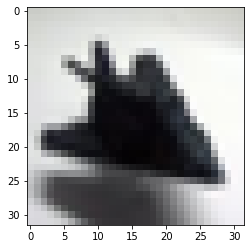

In [ ]:
show_image(*dataset[0])

In [ ]:
# Create validation subset from train set. 
val_size = 5000
train_size = len(dataset) - val_size

train_dl, val_dl = random_split(dataset,[train_size,val_size])
print("Train Dataset size:",len(train_dl),"Test Dataset size:",len(val_dl))

Train Dataset size: 45000 Test Dataset size: 5000


In [ ]:
# Initializae dataloader with batch size
batch_size = 128
train_dl = DataLoader(train_dl,batch_size=batch_size,shuffle=True,num_workers=4,pin_memory=False)
val_dl = DataLoader(val_dl,batch_size=batch_size,num_workers=4,pin_memory=False)

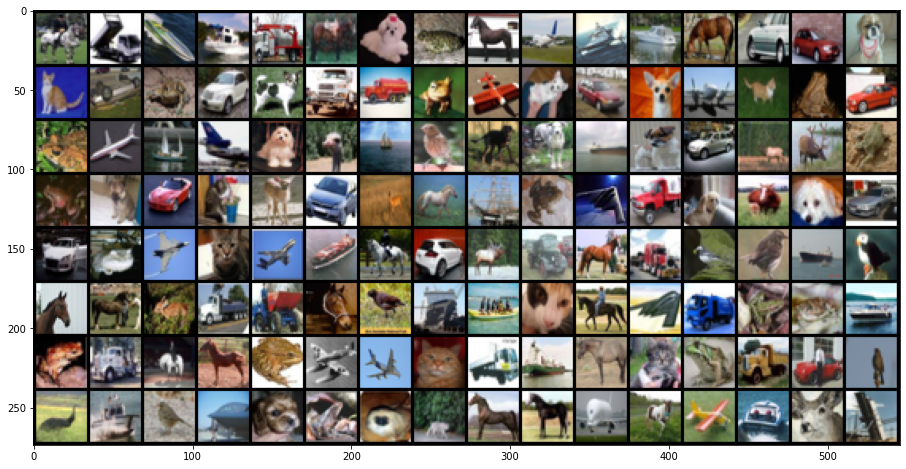

In [ ]:
# Show data as grid
def show_batch(ds):
  for imgs,labels in ds:
    plt.figure(figsize=(16,8))
    plt.imshow(make_grid(imgs,nrow=16).permute(1,2,0))
    break
show_batch(train_dl)

In [ ]:
# Print the batch shape
for imgs,labels in train_dl:
  print(imgs.shape)
  break

torch.Size([128, 3, 32, 32])


# Model 

Create a model class with all the required functions like train step, val step, etc

In [ ]:
# A model class inherits nn.Module class
class ImageClassification(torch.nn.Module):

  def training_step(self,batch):
    imgs,labels = batch
    out = self(imgs)
    loss = F.cross_entropy(out,labels)
    return loss

  def validation_step(self,batch):
    
    imgs,labels = batch
    out = self(imgs)
    loss = F.cross_entropy(out,labels)
    acc = accuracy(out,labels)
    return {'accuracy':acc,'val_loss' : loss.detach()}

  def validation_epoch_end(self,val_dl):
    batch_loss = [self.validation_step((xb,yb))['val_loss'] for xb,yb in val_dl ]
    epoch_loss = torch.stack(batch_loss).mean()
    batch_acc = [self.validation_step((xb,yb))['accuracy'] for xb,yb in val_dl]
    epoch_acc = torch.stack(batch_acc).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
         
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
 # A CNN class that is a child of the parent class - ImageClassification
class Cifar10CnnModel(ImageClassification):
  def __init__(self):
    super().__init__()
    self.network =  torch.nn.Sequential(
    
    torch.nn.Conv2d(3,32,kernel_size = 3,stride = 1,padding=1), # 32*32*3
    torch.nn.ReLU(),
    torch.nn.Conv2d(32,64,kernel_size = 3,stride = 1,padding=1), # 32*32*8
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),                        # 16*16*8

    torch.nn.Conv2d(64,128,kernel_size = 3,stride = 1,padding=1), # 16*16*16
    torch.nn.ReLU(),
    torch.nn.Conv2d(128,128,kernel_size = 3,stride = 1,padding=1), # 16*16*16
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),                        # 8*8*8
    
    torch.nn.Conv2d(128,256,kernel_size = 3,stride = 1,padding=1), # 8*8*256
    torch.nn.ReLU(),
    torch.nn.Conv2d(256,256,kernel_size = 3,stride = 1,padding=1), # 8*8*256
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),                        # 4*4*256

    torch.nn.Conv2d(256,512,kernel_size = 3,stride = 1,padding=1), # 4*4*512
    torch.nn.ReLU(),
    torch.nn.Conv2d(512,512,kernel_size = 3,stride = 1,padding=1), # 4*4*512
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),                        # 4*4*512

    torch.nn.Flatten(),
    torch.nn.Linear(512*2*2,1024),
    torch.nn.Linear(1024,512),
    torch.nn.Linear(512,10),
    
    # torch.nn.Softmax(dim =1)   
    )

  def forward(self,xb):
    out = self.network(xb)
    return out

In [ ]:
# Check the model 
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): Conv2d(512, 51

In [ ]:
# Run a sample prediction to check outputs
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 10])
out[0]: tensor([ 0.0295, -0.0387, -0.0100,  0.0155,  0.0061,  0.0611, -0.0515,  0.0075,
         0.0525, -0.0520], grad_fn=<SelectBackward>)


# GPU Move

In [ ]:
# Create the GPU setup required
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else: 
    return torch.device('cpu')

def to_device(data,device):
  if isinstance(data, (list,tuple)):
    return [to_device(x,device) for x in data]
  return data.to(device, non_blocking = True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
# Check current device
device = get_default_device()
device

device(type='cuda')

In [ ]:
# Move dataset/ dataloaders and model to GPU
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): Conv2d(512, 51

# Training

In [ ]:
# Run the fit function for training
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = model.validation_epoch_end(val_loader)
    return outputs

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history

In [ ]:
# Run the evalute funciton to check the average acccuracy before training
model = to_device(Cifar10CnnModel(), device)
evaluate(model, val_dl)

{'val_acc': 0.09980468451976776, 'val_loss': 2.3028883934020996}

In [ ]:
# Initialize Hyperparameters
num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.8858, val_loss: 1.6891, val_acc: 0.3840
Epoch [1], train_loss: 1.3951, val_loss: 1.2970, val_acc: 0.5307
Epoch [2], train_loss: 1.1377, val_loss: 1.1028, val_acc: 0.6062
Epoch [3], train_loss: 0.9679, val_loss: 0.9641, val_acc: 0.6531
Epoch [4], train_loss: 0.8343, val_loss: 1.0081, val_acc: 0.6514
Epoch [5], train_loss: 0.7192, val_loss: 0.7995, val_acc: 0.7242
Epoch [6], train_loss: 0.6375, val_loss: 0.8163, val_acc: 0.7139
Epoch [7], train_loss: 0.5571, val_loss: 0.7424, val_acc: 0.7508
Epoch [8], train_loss: 0.4969, val_loss: 0.7766, val_acc: 0.7422
Epoch [9], train_loss: 0.4258, val_loss: 0.8350, val_acc: 0.7406
Epoch [10], train_loss: 0.3842, val_loss: 0.8704, val_acc: 0.7264
Epoch [11], train_loss: 0.3349, val_loss: 0.8626, val_acc: 0.7541
Epoch [12], train_loss: 0.2932, val_loss: 0.9011, val_acc: 0.7437
Epoch [13], train_loss: 0.2591, val_loss: 0.9859, val_acc: 0.7475
Epoch [14], train_loss: 0.2386, val_loss: 0.9658, val_acc: 0.7402
Epoch [15], train_lo

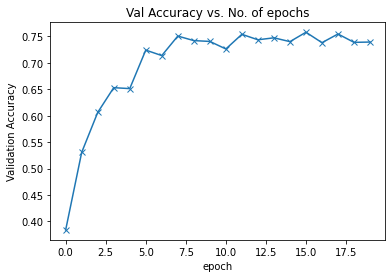

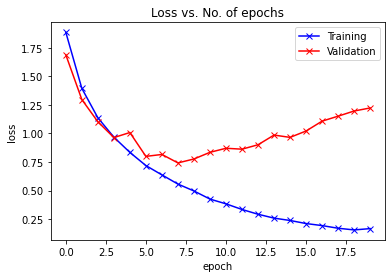

In [ ]:
# Plot the accuracy and loss curve
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.figure()
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('Validation Accuracy')
    plt.title('Val Accuracy vs. No. of epochs');


def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.figure()
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_accuracies(history)
plot_losses(history)

Label: airplane , Predicted: airplane
Label: automobile , Predicted: automobile
Label: frog , Predicted: frog


{'val_acc': 0.740917980670929, 'val_loss': 1.276614785194397}

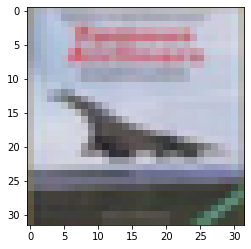

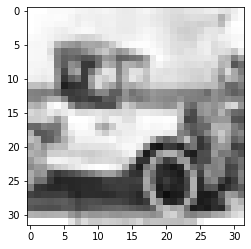

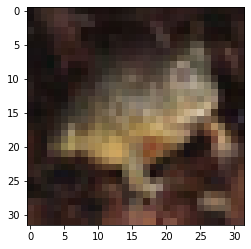

In [ ]:
# Check the performance on test set
test_dataset = ImageFolder('./data/cifar10/test', transform=ToTensor())

def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

plt.figure()
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

plt.figure()
img, label = test_dataset[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

plt.figure()
img, label = test_dataset[6153]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

# Conclusion
* The model performs with ~ 75% accuracy. 
* The model arch needs improvements like regularization, dropout, batch normalization to perform better. 
* In next notebook, we'll try these.